In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy.linalg import det
from numpy.linalg import inv
from numpy.linalg import eig as eigen

In [91]:
"""Код для отчёта по численным методам."""


def right_triangle(grid_zero_level, T, h, tau, lam):
    """
    Код для схемы "правый" треугольник (см. отчёт).

    Параметры:
    ----------

    grid_zero_level: начальные условия
    lam: лямбда из уравнения du / dt = lam * du / dx
    T: решение ищется на сетке [0, 1] \times [0, T]
    (h, \tau): шаг сетки (h, \tau) = (1 / N, T / M)

    """

    # Количество узлов по каждой из осей
    N = round(1 / h)
    M = round(T / tau)

    # Параметр для схемы
    coef = lam * tau / h

    if lam < 0 or coef > 1:
        print("Схема неустойчива")

    # Решение ищем на сетке
    grid = np.zeros((M + 1, N + 1))
    grid[0, :] = grid_zero_level

    for m in range(1, M + 1):
        grid[m, :N] = (1 - coef) * grid[m - 1, :N] \
                        + coef * grid[m - 1, 1:N + 1]
        grid[m, N] = grid[m, 0]

    return grid


def cycle_marching(alpha, beta, gamma, F):
    """
    Вычисляет вектор решений с помощью метода
    циклической прогонки для трехдиагональной
    матрицы, у которой на главной диагонали стоит
    число beta, на нижней -- alpha, на верхней -- gamma

    Параметры:
    ----------
    alpha, beta, gamma: числа на диагоналях
    F: вектор свободных членов

    """

    N = F.shape[0] - 1

    """
    Вводим коэффициенты метода прогонки.

    Из отчета:
    C -> C_n
    phi_q -> \varphi_n^{(q)}
    phi_p -> \varphi_n^{(p)}

    """

    C = np.zeros(N - 1)
    phi_q = np.zeros(N - 1)
    phi_p = np.zeros(N - 1)
    C[0] = -gamma / beta
    phi_p[0] = F[1] / beta
    phi_q[0] = -alpha / beta

    # Вычисляем введенные коэффциенты
    for i in range(1, N - 1):
        denominator = alpha * C[i - 1] + beta
        C[i] = -gamma / denominator
        phi_p[i] = (F[i + 1] - alpha * phi_p[i - 1]) / denominator
        phi_q[i] = -(alpha * phi_q[i - 1]) / denominator

    # Из отчета: p -> p_n, q -> q_n
    p = np.zeros(N - 1)
    q = np.zeros(N - 1)
    p[N - 2] = phi_p[N - 2]
    q[N - 2] = C[N - 2] + phi_q[N - 2]
    for i in reversed(range(N - 2)):
        p[i] = C[i] * p[i + 1] + phi_p[i]
        q[i] = C[i] * q[i + 1] + phi_q[i]

    # Из отчета z_N -> z_N
    z_N = ((F[N] - gamma * p[0] - alpha * p[N-2]) /
           (beta + gamma * q[0] + alpha * q[N - 2]))

    appended = np.append(z_N, p + q * z_N)
    return np.append(appended, z_N)


def upper_triangle(grid_zero_level, T, h, tau, lam):
    """
    Код для схемы "верхний" треугольник (см. отчёт).

    Параметры:
    ----------

    grid_zero_level: начальные условия
    lam: лямбда из уравнения du / dt = lam * du / dx
    T: решение ищется на сетке [0, 1] x [0, T]
    (h, \tau): шаг сетки (h, \tau) = (1 / N, T / M)

    """

    # Количество узлов по каждой из осей
    N = round(1 / h)
    M = round(T / tau)

    # Параметр для схемы
    coef = lam * tau / h

    if abs(coef) > 1:
        print("Циклическая прогонка неустойчива")

    # Решение ищем на сетке
    grid = np.zeros((M + 1, N + 1))
    grid[0, :] = grid_zero_level

    alpha = coef / 2
    beta = 1
    gamma = -coef / 2
    for m in range(1, M + 1):
        grid[m, :] = cycle_marching(alpha, beta, gamma, grid[m - 1, :])

    return grid


def solve(A, init_f1, init_f2, T, h, tau, method):
    """
    Решает задачу du / dt = A du / dx, где
        u -- вектор (u_1, u_2)^T,
        A -- матрица 2x2
    c начальными условиями
        u(0, t) = u(1, t)
        u(x, 0) = (init_f1(x), init_f2(x))^T
    на [0, 1] x [0, T]

    с помощью разностной схемы method на сетке
    с шагом (h, \tau) = (1 / N, T / M)

    Параметры:
    ----------
    A: матрица 2x2. Например, [[1,0],[0,1]]
    init_f1: функция из н. у.
        Например, init_f1 = lambda x: math.sin(2 * math.pi * x)
    init_f2: вторая функция из н. у.
        Например, аналогично init_f1
    T: ищем решение в области [0, 1] x [0, T]
    (h, \tau): шаг сетки (h, \tau) = (1 / N, T / M)
    method: разностная схема. Например, method = upper_triangle

    """
    N = round(1 / h)
    M = round(T / tau)

    # Приводим A к диагональному виду
    eigen_data = eigen(A)
    C = np.array(eigen_data[1]).T
    inv_C = inv(C)
    A = np.diag(eigen_data[0])

    # Преобразуем функции из н.у.
    def ltransformed_init_f1(x):
        return np.dot(inv_C[0], np.array([init_f1(x), init_f2(x)]))

    def ltransformed_init_f2(x):
        return np.dot(inv_C[1], np.array([init_f1(x), init_f2(x)]))

    # Считаем н.у.
    x_grid = np.arange(N + 1) / N
    init_array_f1 = np.empty(N + 1)
    init_array_f2 = np.empty(N + 1)
    for n in range(N + 1):
        init_array_f1[n] = ltransformed_init_f1(x_grid[n])
        init_array_f2[n] = ltransformed_init_f2(x_grid[n])

    # Решаем с помощью соответствующей разностной схемы
    grid1 = method(init_array_f1, T, h, tau, A[0, 0])
    grid2 = method(init_array_f2, T, h, tau, A[1, 1])

    # Берем от решения C^{-1}
    stacked_grid = np.vstack([grid1.ravel(), grid2.ravel()])
    ltransformed_grid1 = np.dot(inv_C[0], stacked_grid).reshape(grid1.shape)
    ltransformed_grid2 = np.dot(inv_C[1], stacked_grid).reshape(grid1.shape)

    return (ltransformed_grid1, ltransformed_grid2, T)


def plot_grid(title, solution_grid, T, T_sect_arr):
    """
    Рисует график сетки значений solution_grid при t из T_sect_arr

    Параметры:
    ----------
    title: название графика
    solution_grid: сетка значений. Тип: ndarray
    T_sect_arr: значения переменной t, для которых мы берём график сечений.
        Например, T_sect_arr = [0, 0.1, 0.4, 0.7, 1]

    """

    # Параметры сетки
    M, N = solution_grid.shape
    M = M - 1
    N = N - 1
    tau = T / M
    h = 1 / N

    # Задаем параметры графика
    plt.figure(figsize=(7, 3))
    ax = plt.subplot(111)

    # Рисуем сечения
    for t in T_sect_arr:
        m = math.floor(t / tau)
        ax.plot(np.arange(N + 1) / N, solution_grid[m, :],
                label="t=%.2f" % (m * tau))

    # Прихорашиваем график
    ax.set_xticks(np.linspace(0.0, 1.0, num=11))
    leg = plt.legend(loc='upper right', ncol=1)
    plt.title(title)
    plt.ylabel(title)
    plt.xlabel("x")
    ax.grid()
    plt.show()


def plot(solution, T_sect_arr):
    """
    Рисует график сечений решения solution при t из T_sect_arr

    Параметры:
    ----------
    solution: 3-tuple рещения
    T_sect_arr: значения переменной t, для которых мы берём график сечений.
        Например, T_sect_arr = [0, 0.1, 0.4, 0.7, 1]

    """
    T = solution[2]
    plot_grid("u1", solution[0], T, T_sect_arr)
    plot_grid("u2", solution[1], T, T_sect_arr)

In [96]:
'''Начальные функции'''

def f1(x):
    return math.sin(2 * np.pi * x)

def f2(x):
    return math.cos(2 * np.pi * x) + 0.1 * math.sin(50 * np.pi * x)

In [97]:
my_upper_solution = solve([[1,0],[0,1]], f1, f2, 1, h = 0.005, tau = 0.005, method = upper_triangle)

In [94]:
my_right_solution = solve([[1,0],[0,1]], f1, f2, 1, h = 0.005, tau = 0.001, method = right_triangle)

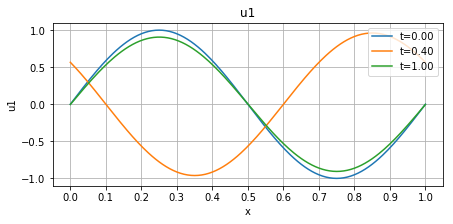

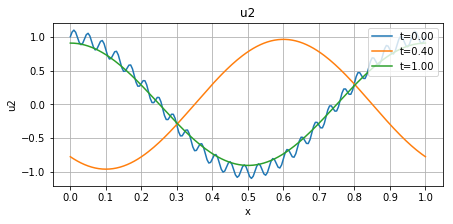

In [99]:
plot(my_upper_solution, [0, 0.4, 1])

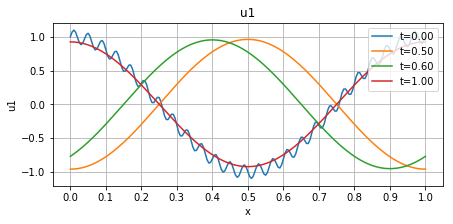

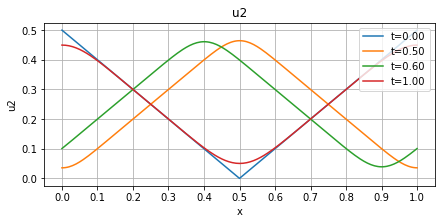

In [75]:
plot(my_right_solution, [0, 0.5, 0.6, 1])